# Federated learning: Simple experiment

In this notebook we provide a simple example of how to make an experiment of a federated environment with the help of this framework. We are going to use a popular dataset to start the experimentation in a federated environment. The framework provides some functions to load the [Emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset) Digits dataset.

In [1]:
from shfl.data_base.emnist import Emnist

database = Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()

Let's inspect some properties of the loaded data.

In [2]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data[0]))
train_data[0].shape

199999
40000
40000
<class 'numpy.ndarray'>


(28, 28)

So, as we have seen, our dataset is composed by a set of matrixes of 28 by 28. Before starting with the federated scenario, we can take a look to a sample in the training data.

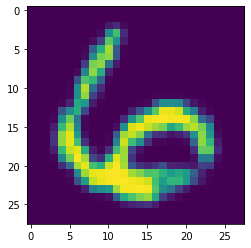

In [4]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0])

We are going to simulate a federated learning scenario with a set of client nodes containing private data, and a central server that will be responsible to coordinate the different clients. But, first of all, we have to simulate the data contained in every client. In order to do that, we are going to use the previous dataset loaded. The assumption in this example will be the data is distributed as a set of independent and identically distributed random variables, having every node more o less the same amount of data. There are a set of different posibilities in order to distribute the data. The distribution of the data is one of the factor that could impact more to a federated algorithm. Therefore, the framework contains the implementation of some of the most common distribution that allow you experiment different situations easily. In this [link]() you can dig into the options that the framework provides at the moment.

In [6]:
from shfl.data_distribution.data_distribution_iid import IidDataDistribution
from shfl.core.node import DataNode

iid_distribution = IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data("emnist", 20, percent=10)

That's it. We have created federated data from the Emnist dataset with 20 nodes and using only 10 percent of the available data. This data is a set of data nodes containing private data. This private data needs a identifier that we have provided in the creation of the federated data, in this case "emnist". Let's learn a little about the federated data.

In [7]:
print(type(federated_data))
print(federated_data.num_nodes())
federated_data[0].private_data

<class 'shfl.core.data.FederatedData'>
20
Node private data, you can see the data for debug purposes but the data remains in the node
<class 'dict'>
{'emnist': <shfl.core.data.LabeledData object at 0x12162f5d0>}


As we can see, private data in a node is not accesible directly but the framework provides mechanisms to use this data in a machine learning model. A federated learning algorithm is defined by a local model to learn from data in every node and a way to aggregate the different model parameters in a central node. In this example we will use a deep learning model using keras to build it. The framework provides a class to adapt a Keras model to the framework, your job is only create a function that will act as model builder.

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from shfl.model.deep_learning_model import KerasDeepLearningModel

def model_builder():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Dropout(0.4))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return KerasDeepLearningModel(model)

Now, we a model to deploy over nodes a set of nodes with data. The only piece missing is the aggregation operator. Nevertheless the framework provides some aggregation operators that we can use inmediatly. In the following piece of code we define the federated algorithm.

In [10]:
from shfl.learning_approach.learning_approach import LearningApproach
from shfl.learning_approach.federated_government import FederatedGovernment
from shfl.federated_aggregator.fsvrg_aggregator import AvgFedAggregator

aggregator = AvgFedAggregator()
federated_government = FederatedGovernment(model_builder, federated_data, aggregator)

If you want to see all the aggregation operators you can follow the following [link](). Before executing the algorithm we want to make a data transformation. The good practise to do that is to define a federated operation that will be apply over every node. We want to reshape the data, so we define the following FederatedTransformation.

In [13]:
import numpy as np
import keras

import shfl.core.federated_operation
from shfl.core.federated_operation import FederatedTransformation

class Reshape(FederatedTransformation):
    
    def apply(self, labeled_data):
        labeled_data.data = np.reshape(labeled_data.data, (labeled_data.data.shape[0], labeled_data.data.shape[1], labeled_data.data.shape[2],1))
        labeled_data.label = keras.utils.to_categorical(labeled_data.label, 10)
        
shfl.core.federated_operation.apply_federated_transformation(federated_data, Reshape())

We are now ready to execute our federated learning algorithm.

In [14]:
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2],1))
federated_government.run_rounds(3, test_data, test_label)

Accuracy round 0
Test Accuracy Client <shfl.core.node.DataNode object at 0x12162f7d0>: 0.36105
Test Accuracy Client <shfl.core.node.DataNode object at 0x12162f950>: 0.3454
Test Accuracy Client <shfl.core.node.DataNode object at 0x12162fd10>: 0.360075
Test Accuracy Client <shfl.core.node.DataNode object at 0x12167f610>: 0.46015
Test Accuracy Client <shfl.core.node.DataNode object at 0x12167fe50>: 0.435575
Test Accuracy Client <shfl.core.node.DataNode object at 0x12167ff50>: 0.421575
Test Accuracy Client <shfl.core.node.DataNode object at 0x12167ffd0>: 0.410925
Test Accuracy Client <shfl.core.node.DataNode object at 0x121682090>: 0.38065
Test Accuracy Client <shfl.core.node.DataNode object at 0x121682110>: 0.39785
Test Accuracy Client <shfl.core.node.DataNode object at 0x121682150>: 0.3938
Test Accuracy Client <shfl.core.node.DataNode object at 0x1216821d0>: 0.352025
Test Accuracy Client <shfl.core.node.DataNode object at 0x121682250>: 0.39835
Test Accuracy Client <shfl.core.node.DataNod